<a href="https://colab.research.google.com/github/JasonDalton/DigitalVista/blob/master/notebooks/DepthPro_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces inference with [DepthPro](https://huggingface.co/docs/transformers/main/en/model_doc/depthpro) model for depth estimation intorduced by Apple.

- DepthPro is zero-shot monocular **metric** depth estimation network.
- The whole network operates at a fixed resolution of 1536×1536 to achieve super sharp depth estimation while avoiding OOM errors for larger images.
- The network comes with an optional focal length estimation head. A small convolutional head, which ingests frozen features from the depth estimation network and task-specific features from a separate ViT image encoder to predict the horizontal angular field-of-view (FoV).

Abstract:  

*We present a foundation model for zero-shot metric monocular depth estimation. Our model, Depth Pro, synthesizes high-resolution depth maps with unparalleled sharpness and high-frequency details. The predictions are metric, with absolute scale, without relying on the availability of metadata such as camera intrinsics. And the model is fast, producing a 2.25-megapixel depth map in 0.3 seconds on a standard GPU. These characteristics are enabled by a number of technical contributions, including an efficient multi-scale vision transformer for dense prediction, a training protocol that combines real and synthetic datasets to achieve high metric accuracy alongside fine boundary tracing, dedicated evaluation metrics for boundary accuracy in estimated depth maps, and state-of-the-art focal length estimation from a single image. Extensive experiments analyze specific design choices and demonstrate that Depth Pro outperforms prior work along multiple dimensions.*

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/depth_pro_architecture.png)
![](https://github.com/apple/ml-depth-pro/blob/main/data/depth-pro-teaser.jpg?raw=true)



 - Paper: https://arxiv.org/abs/2410.02073
 - Project Page: https://promptda.github.io/

In this notebook we will cover the following steps:  

 - Loading an image
 - Loading pretrained model and image_processor from [HuggingFace Hub](https://huggingface.co/models?other=prompt_depth_anything)
 - Inference WITHOUT FoV (field of view)
 - Inference WITH FoV
 - Visualization of predicted depth maps

But first, let make sure we have the lates `transformers` installed:

In [1]:
!pip install -U -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import requests
import numpy as np

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

print(f"Device: {device}")

Device: cuda


### Load data

Image size: [619, 1100]


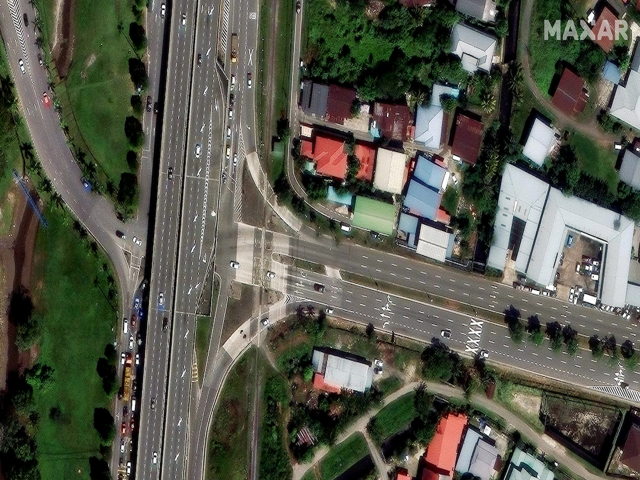

In [8]:
# image for depth estimation
#url = "https://github.com/apple/ml-depth-pro/blob/main/data/example.jpg?raw=true"
url = "https://maxar-blog-assets.s3.amazonaws.com/uploads/blogImages/Kota-Kinabalu_Malaysia_Maxar-Vivid-Advanced-basemap_15-cm-HD_2024.png"
image = Image.open(requests.get(url, stream=True).raw)


# Convert the image to RGB format before further processing.
image = image.convert('RGB')

print("Image size:", [image.height, image.width])
image.resize((640, 480)) # resize for visualization

### Load model and image processor from the Hugging Face Hub

Image processor is an object responsible for image normalization/resizing and results posprocessing, such as resizing depth map back to the image scale.

In [9]:
checkpoint = "apple/DepthPro-hf"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)
model = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype
)

# In case you don't need FoV and want to save some memory and compute
model_no_fov = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype, use_fov_model=False
)

### Inference with FoV

In [10]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

print(f"Model outputs: {outputs.keys()}")
print(f"Model predicted depth (raw) shape: {outputs['predicted_depth'].shape}")

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output

Preprocessed inputs: dict_keys(['pixel_values'])
Model outputs: odict_keys(['predicted_depth', 'field_of_view'])
Model predicted depth (raw) shape: torch.Size([1, 1536, 1536])


[{'predicted_depth': tensor([[3.9844, 4.3281, 4.3672,  ..., 4.7891, 4.6992, 4.7617],
          [4.3359, 4.3242, 4.3594,  ..., 4.7109, 4.7070, 4.7344],
          [4.3398, 4.3281, 4.3125,  ..., 4.6836, 4.6953, 4.7617],
          ...,
          [4.0430, 4.0117, 4.0039,  ..., 5.1602, 5.1836, 5.1797],
          [4.0117, 4.0312, 4.0234,  ..., 5.1562, 5.2031, 5.1328],
          [3.8926, 4.0039, 4.0078,  ..., 5.1055, 5.0742, 4.7266]],
         device='cuda:0', dtype=torch.float16),
  'field_of_view': tensor(63.1875, device='cuda:0', dtype=torch.float16),
  'focal_length': tensor(895., device='cuda:0', dtype=torch.float16)}]

In [11]:
predicted_depth = post_processed_output[0]["predicted_depth"]

min = predicted_depth.min().item()
max = predicted_depth.max().item()

print("Predicted depth shape:", predicted_depth.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([619, 1100])
Predicted depth range: 3.55..5.21 (meters)


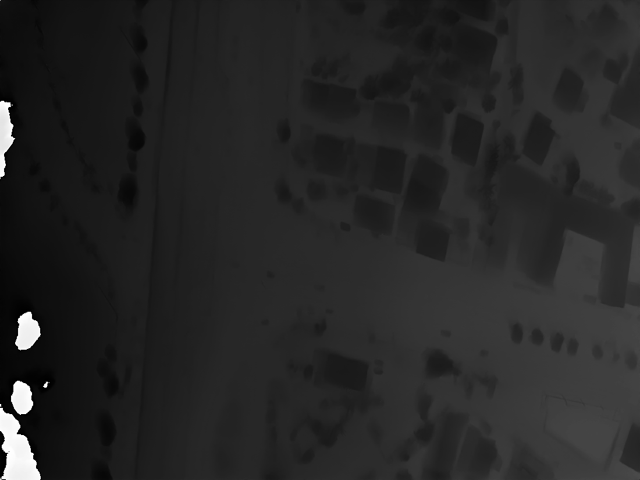

In [12]:
# Visualize the prediction
# Let's normalize it with respect to 4 meters depth (beacuse maximum depth is 3.08)
# JUST for visualization and comparison with NO FoV model
max_depth = 4
normalized_depth = predicted_depth.cpu().numpy() / max_depth
normalized_depth = Image.fromarray((normalized_depth * 255).astype("uint8"))

normalized_depth.resize([640, 480])

### Inference without FoV

In [13]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model_no_fov(**inputs)

print(f"Model outputs: {outputs.keys()}")
print(f"Model predicted depth (raw) shape: {outputs['predicted_depth'].shape}")

# interpolate to original size
post_processed_outputno_fov = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_outputno_fov

Preprocessed inputs: dict_keys(['pixel_values'])
Model outputs: odict_keys(['predicted_depth'])
Model predicted depth (raw) shape: torch.Size([1, 1536, 1536])


[{'predicted_depth': tensor([[4.8984, 5.3242, 5.3711,  ..., 5.8906, 5.7734, 5.8516],
          [5.3281, 5.3125, 5.3555,  ..., 5.7891, 5.7812, 5.8164],
          [5.3359, 5.3203, 5.3008,  ..., 5.7578, 5.7695, 5.8477],
          ...,
          [4.9727, 4.9336, 4.9219,  ..., 6.3398, 6.3750, 6.3633],
          [4.9336, 4.9570, 4.9453,  ..., 6.3359, 6.3906, 6.3047],
          [4.7891, 4.9219, 4.9258,  ..., 6.2773, 6.2344, 5.8125]],
         device='cuda:0', dtype=torch.float16),
  'field_of_view': None,
  'focal_length': None}]

In [14]:
predicted_depth_no_fov = post_processed_outputno_fov[0]["predicted_depth"]

min = predicted_depth_no_fov.min().item()
max = predicted_depth_no_fov.max().item()

print("Predicted depth shape:", predicted_depth_no_fov.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([619, 1100])
Predicted depth range: 4.37..6.40 (meters)


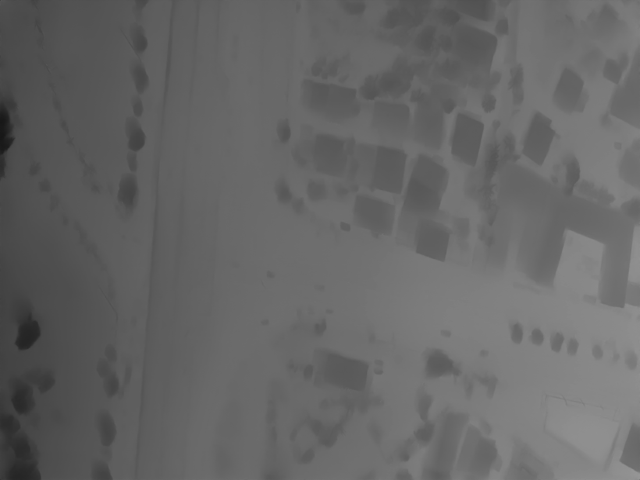

In [15]:
# Visualize the prediction
# Also romalize to max_depth=4 to make comparison FoV / no FoV models
normalized_depth_no_fov = predicted_depth_no_fov.cpu().numpy() / max_depth
normalized_depth_no_fov = Image.fromarray((normalized_depth_no_fov * 255).astype("uint8"))

normalized_depth_no_fov.resize([640, 480])

### Visualize all together

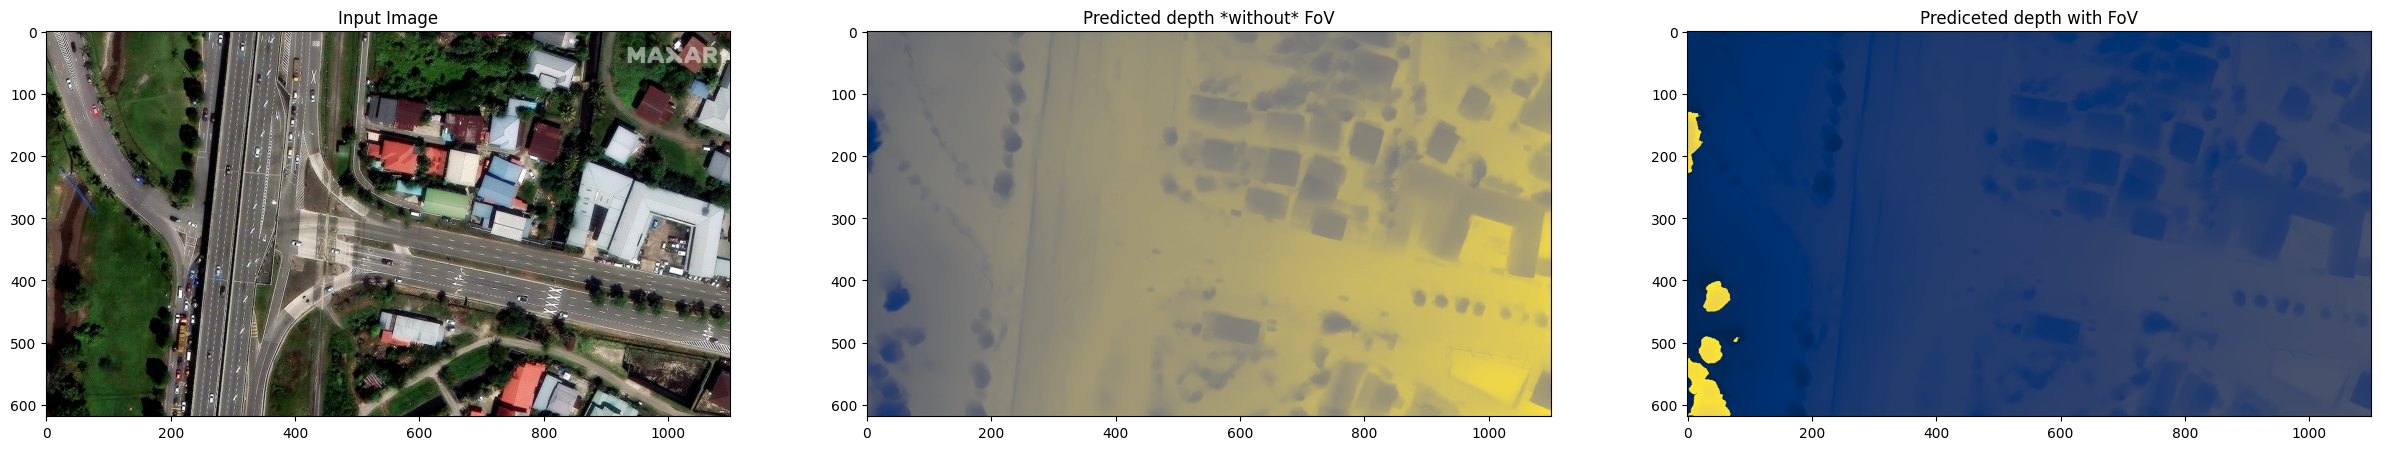

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 20))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Predicted height *without* FoV")
plt.imshow(normalized_depth_no_fov, cmap='cividis')

plt.subplot(1, 3, 3)
plt.title("Prediceted height with FoV")
plt.imshow(normalized_depth, cmap='cividis')

plt.show()